# CS F429 - NLP Project
Project 1: Grammar Check for English Language

## Problem Statement
Part 1: Build a grammar checker using the concepts taught in class, you will be given a corpus with some paragraphs labeled
correct and unknown; correct paragraphs have no grammatical errors, while unknown may/may not have sentences
which have grammatical errors in them. The task is to find all the sentences that have these errors. For example: “In the
country there lived a fox. The quick brown fox jump over the fence. Farmer Shaun was terrified.” In this paragraph, the
sentence “The quick brown fox jump over the fence” is grammatically incorrect.

## Introduction

### Importing libraries

In [1]:
!pip install dill
!pip install -U nltk

In [2]:
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import random
import time
import nltk
import random
import spacy
import ssl
from numpy import inf

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
nltk.download('punkt')
nltk.download('brown')
from nltk.corpus import brown

# from google.colab import drive
# drive.mount('/content/gdrive')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/adarshnandanwar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /home/adarshnandanwar/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [3]:
# BASE_DIR = 'gdrive/MyDrive/nlp_project'
BASE_DIR = os.getcwd()
DATASET_PATH = os.path.join(BASE_DIR, 'dataset', 'NLP_Q1')
CLEAN_DATASET_PATH = os.path.join(DATASET_PATH, 'clean')
UNKNOWN_DATASET_PATH = os.path.join(DATASET_PATH, 'unknown')

PRINT_LIMIT = 3

### Importing dataset

In [4]:
# Extracting dataset
from zipfile import ZipFile

if not os.path.isdir(DATASET_PATH):
    dataset_zip_path = os.path.join(BASE_DIR, 'dataset', 'Topic 1.zip')
    dataset_extrat_path = os.path.join(BASE_DIR, 'dataset')
    with ZipFile(dataset_zip_path, 'r') as zip:
        zip.printdir()
        zip.extractall(dataset_extrat_path)
        print('Done!')
else:
    print('Dataset already extracted')

Dataset already extracted


In [5]:
# Reading clean dataset
clean_text_list = []
for file_name in os.listdir(CLEAN_DATASET_PATH):
    text = open(os.path.join(CLEAN_DATASET_PATH, file_name)).read()
    clean_text_list.append(text)

print(f'Size of clean dataset: {len(clean_text_list)}')
print(f'===========================\n')
print('\n\n'.join(random.sample(clean_text_list, PRINT_LIMIT)))

Size of clean dataset: 6969

`` Shake '' , I said . `` You have just enlisted for the ' Rhine Campaign ' '' .

He staggered into the back seat and lay back , fighting for breath . There was someone in front with the sheriff . It was Pete Holmes , the cabdriver .

A good feeling prevailed on the SMU coaching staff Monday , but attention quickly turned from Saturday's victory to next week's problem : Rice University . The Mustangs don't play this week .


In [6]:
# Reading unknown dataset
unknown_text_list = []
for file_name in os.listdir(UNKNOWN_DATASET_PATH):
    text = open(os.path.join(UNKNOWN_DATASET_PATH, file_name)).read()
    unknown_text_list.append(text)

print(f'Size of unknown dataset: {len(unknown_text_list)}')
print(f'=============================\n')
print('\n\n'.join(random.sample(unknown_text_list, PRINT_LIMIT)))

Size of unknown dataset: 8698

With the metal shutters closed , the dining room was so dark that it seemed still night in there . One of the drawing - room shutters was partly open and he made out the shapes of chairs and sofas , whicher seemed to be upholstered in brown or russet velvet . The curtains were of the same material , and there were some big oil paintings -- portraits in ther style of Lancret and Boucher .

A recent example of this problem is the flying of six airplanes , on December 31 , 1960 , from the Newport Airpark in Middletown , to the North Central affections Airport in Smithfield . This situation resulted in both towns claimest the tax , and probably justifiably . Middletown bases its claim on the general provision of the law that ` ` all rateable property , both tangible and intangible , shall be taxed to the owner thereof in the town in which such owner shall have had his actual place of abode for the larger portion of the twelve ( 12 ) months next preceding the 

In [7]:
from nltk.tokenize import sent_tokenize

def segmentation(corpus):
    segmented_corpus = []
    map_to_corpus_index = []
    for i, text in enumerate(corpus):
        splits = sent_tokenize(text)
        segmented_corpus.extend(splits)
        map_to_corpus_index.extend([i for x in range(len(splits))])
    return segmented_corpus, map_to_corpus_index

In [8]:
from nltk.tokenize import word_tokenize

def tokenization(segmented_corpus):
    tokenized_corpus = []
    for text in segmented_corpus:
        tokenized_corpus.append(word_tokenize(text))
    return tokenized_corpus

In [9]:
segmented_clean_text_list, map_to_corpus_index = segmentation(clean_text_list)
tokenized_clean_text_list = tokenization(segmented_clean_text_list)

print('Segmentation of clean data')
print('==========================\n')
print('\n\n'.join(segmented_clean_text_list[:PRINT_LIMIT]))
print('\n\nTokenization of clean data')
print('==========================\n')
for i in range(PRINT_LIMIT):
    print(tokenized_clean_text_list[i], end='\n\n')

Segmentation of clean data

The jury further said in term-end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted .

It urged that the next Legislature `` provide enabling funds and re-set the effective date so that an orderly implementation of the law may be effected '' .

The grand jury took a swipe at the State Welfare Department's handling of federal funds granted for child welfare services in foster homes .


Tokenization of clean data

['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', '``', 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.']

['It', 'urged', 'that', 'the', 

In [10]:
segmented_unknown_text_list, map_to_corpus_index = segmentation(unknown_text_list)
tokenized_unknown_text_list = tokenization(segmented_unknown_text_list)

print('Segmentation of unknown data')
print('============================\n')
print('\n\n'.join(segmented_unknown_text_list[:PRINT_LIMIT]))
print('\n\nTokenization of unknown data')
print('============================\n')
for i in range(PRINT_LIMIT):
    print(tokenized_unknown_text_list[i], end='\n\n')

Segmentation of unknown data

The Fulton County Grand Jury say Friday an investigation of Atlanta 's recent primary election produced ` ` no evidence '' that any irregularities took place .

` ` This is one of the major items in the Fulton County general assistance program '' , the jury said , but the State Welfare Department ` ` has seen fit to distribute these funds through the welfare departments of all the counties in the state with the exception of Fulton County , which receives reform none of this money .

The jurors said they realize ` ` a proportionate distribution of these funder might disable this program in our less populous counties '' .


Tokenization of unknown data

['The', 'Fulton', 'County', 'Grand', 'Jury', 'say', 'Friday', 'an', 'investigation', 'of', 'Atlanta', "'s", 'recent', 'primary', 'election', 'produced', '`', '`', 'no', 'evidence', '``', 'that', 'any', 'irregularities', 'took', 'place', '.']

['`', '`', 'This', 'is', 'one', 'of', 'the', 'major', 'items', 'in'

### Dataset Analysis

In [11]:
# Building list of all tokens in clean data
token_list_clean = list()
for i in range(len(tokenized_clean_text_list)):
    token = tokenized_clean_text_list[i]
    for j in range(len(token)):
        token_list_clean.append(token[j])
        
# Building set of all tokens in clean data
token_set_clean = set()
for i in range(len(tokenized_clean_text_list)):
    token = tokenized_clean_text_list[i]
    for j in range(len(token)):
        token_set_clean.add(token[j])

In [12]:
# Building list of all tokens in unknown data
token_list_unknown = list()
for i in range(len(tokenized_unknown_text_list)):
    token = tokenized_unknown_text_list[i]
    for j in range(len(token)):
        token_list_unknown.append(token[j])

# Building set of all tokens in unknown data
token_set_unknown = set()
for i in range(len(tokenized_unknown_text_list)):
    token = tokenized_unknown_text_list[i]
    for j in range(len(token)):
        token_set_unknown.add(token[j])

In [13]:
# Calculating function words in clean set
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
num_function_words = 0
for i in range(len(token_list_clean)):
    if(token_list_clean[i] not in sw_spacy):
        num_function_words+=1

print(f"Number of function words:", num_function_words)

Number of function words: 299033


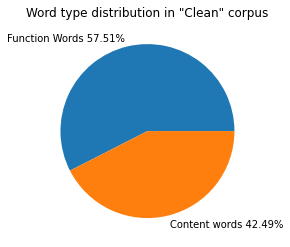

In [14]:
import matplotlib.pyplot as plt
import numpy as np
function_word_percent = round(num_function_words/(len(token_list_clean)) * 100,2)
content_word_percent = round((len(token_list_clean)-num_function_words)/(len(token_list_clean)) * 100,2)
y = np.array([num_function_words, len(token_list_clean)-num_function_words])
mylabels = ["Function Words "+str(function_word_percent)+"%", "Content words "+str(content_word_percent)+"%"]

plt.pie(y, labels = mylabels)
plt.title('Word type distribution in "Clean" corpus')
plt.show()

In [15]:
# Demonstrating Zipf's law
def CountFrequency(my_list):
    freq = {}
    for item in my_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    return freq

In [16]:
mp = CountFrequency(token_list_unknown)

num_list = []
for key in mp.keys():
    num_list.append(mp[key])

num_list.sort(reverse = True)
num_list = num_list[:80]

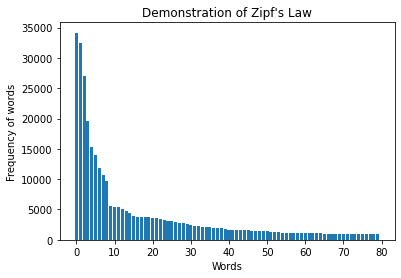

In [17]:
plt.bar(list(range(len(num_list))),num_list)
plt.xlabel("Words")
plt.ylabel("Frequency of words")
plt.title("Demonstration of Zipf's Law")
plt.show()

In [18]:
# Calculation of unknown words in test set

num_unknown_words = 0
test_tokens = list(token_set_unknown)
clean_tokens = list(token_set_clean)
for i in range(len(test_tokens)):
    if(test_tokens[i] not in clean_tokens):
        num_unknown_words+= mp[test_tokens[i]]

print(f"Number of unknown words: ", num_unknown_words)
if num_unknown_words > 0:
    print("OOV words detected!")

Number of unknown words:  45107
OOV words detected!


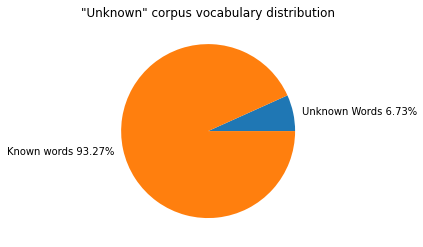

In [19]:
unknown_word_percent = round(num_unknown_words/(len(token_list_unknown)) * 100,2)
known_word_percent = round((len(token_list_unknown)-num_unknown_words)/(len(token_list_unknown)) * 100,2)
y = np.array([num_unknown_words, len(token_list_unknown)-num_unknown_words])
mylabels = ["Unknown Words "+str(unknown_word_percent)+"%", "Known words "+str(known_word_percent)+"%"]
plt.pie(y, labels = mylabels)
plt.title('"Unknown" corpus vocabulary distribution')
plt.show()

## POS Tagging
- We have implemented 2 methods to do POS tagging

### 1. Hiden Markov Model
We can use hidden markov model to do POS tagging on the token. In the below function, we first find the required probabilities (emission probability, transition probability) using the brown corpus made available by nltk library and use these probabilities to do POS tagging on the given training and testing dataset using Viterbi algorithm.

In [20]:
def training_hmm():
    
    print('Training HMM model ......')
    
    sent_tag = brown.tagged_sents()
    train_data=[]
    for s in sent_tag:
        s.insert(0,('<s>','<s>'))
        s.append(('</s>','</s>'))
        train_data.append(s)
    
    train_word_tag = {}
    for s in train_data:
        for (w,t) in s:
            w=w.lower()
            try:
                try:
                    train_word_tag[t][w]+=1
                except:
                    train_word_tag[t][w]=1
            except:
                train_word_tag[t]={w:1}
        
    train_emission_prob={}
    for k in train_word_tag.keys():
        train_emission_prob[k]={}
        count = sum(train_word_tag[k].values())
        for k2 in train_word_tag[k].keys():
            train_emission_prob[k][k2]=train_word_tag[k][k2]/count
            
    print('Calculated emission probability .........')
            
    bigram_tag_data = {}
    for s in train_data:
        bi=list(nltk.bigrams(s))
        for b1,b2 in bi:
            try:
                try:
                    bigram_tag_data[b1[1]][b2[1]]+=1
                except:
                    bigram_tag_data[b1[1]][b2[1]]=1
            except:
                bigram_tag_data[b1[1]]={b2[1]:1}
                
    bigram_tag_prob={}
    for k in bigram_tag_data.keys():
        bigram_tag_prob[k]={}
        count=sum(bigram_tag_data[k].values())
        for k2 in bigram_tag_data[k].keys():
            bigram_tag_prob[k][k2]=bigram_tag_data[k][k2]/count
            
    print('Calculated bigram transition probability .........')
            
    
    tags_of_tokens = {}
    count=0
    for s in train_data:
        for (w,t) in s:
            w=w.lower()
            try:
                if t not in tags_of_tokens[w]:
                    tags_of_tokens[w].append(t)
            except:
                l = []
                l.append(t)
                tags_of_tokens[w] = l
    
    print('Model training completed .........')
    
    return bigram_tag_prob, train_emission_prob, tags_of_tokens

In [21]:
def find_pos_tags_hmm(bigram_tag_prob, train_emission_prob, tags_of_tokens, string_seq):
    string_seq.append('</s>')
    string_seq.insert(0,'<s>')
    s = string_seq
    # storing_values is a dictionary which stores the required values          
    storing_values = {}              
    for q in range(len(s)):
        step = s[q]
        # for the starting word of the sentence
        if q == 1:                
            storing_values[q] = {}
            try:
                tags = tags_of_tokens[step]
            except:
                # print(step+'.....')
                tags = ['UNK']
            for t in tags:
                # this is applied since we do not know whether the word in the test data is present in train data or not
                try:
                    storing_values[q][t] = ['<s>',bigram_tag_prob['<s>'][t]*train_emission_prob[t][step]]
                # if word is not present in the train data but present in test data we assign a very low probability of 0.0001
                except:
                    storing_values[q][t] = ['<s>',0.0001]
    
        # if the word is not at the start of the sentence
        if q>1:
            storing_values[q] = {}
            previous_states = list(storing_values[q-1].keys())  
            try:
                current_states  = tags_of_tokens[step]      
            except:
                current_states = ['UNK']
            # calculation of the best previous state for each current state and then storing it in storing_values
            for t in current_states:                             
                temp = []
                for pt in previous_states:                         
                    try:
                        temp.append(storing_values[q-1][pt][1]*bigram_tag_prob[pt][t]*train_emission_prob[t][step])
                    except:
                        temp.append(storing_values[q-1][pt][1]*0.0001)
                max_temp_index = temp.index(max(temp))
                best_pt = previous_states[max_temp_index]
                storing_values[q][t]=[best_pt,max(temp)]

    # Backtracing to extract the best possible tags for the sentence
    pred_tags = []
    total_steps_num = storing_values.keys()
    last_step_num = max(total_steps_num)
    for bs in range(len(total_steps_num)):
        step_num = last_step_num - bs
        if step_num == last_step_num:
            pred_tags.append('</s>')
            pred_tags.append(storing_values[step_num]['</s>'][0])
        if step_num<last_step_num and step_num>0:
            pred_tags.append(storing_values[step_num][pred_tags[len(pred_tags)-1]][0])
    return list(reversed(pred_tags[1:-1]))

In [22]:
bigram_tag_prob, train_emission_prob, tags_of_tokens = training_hmm()

Training HMM model ......
Calculated emission probability .........
Calculated bigram transition probability .........
Model training completed .........


In [23]:
# Sentence sequence should be like ['<s>' , '.........' , '........' , '</s>']
find_pos_tags_hmm(bigram_tag_prob, train_emission_prob, tags_of_tokens, ['that','is','a','human'])

['DT', 'BEZ', 'AT', 'JJ']

### Method 2. Spacy Library
We can use spacy `en_core_web_sm` which is a english pipeline trained on various corpora to do POS tagging on the given training and testing dataset.

In [24]:
def train_spacy_pos():
    print('Training spacy model ......')
    nlp_spacy = spacy.load("en_core_web_sm")
    print('Training spacy model completed ......')
    return nlp_spacy

In [25]:
def find_pos_tags_spacy(nlp_spacy , text):
    text = ' '.join(text)
    doc = nlp_spacy(text)
    token = [token.tag_  for token in doc]    
    return token

In [26]:
nlp_spacy = train_spacy_pos()

Training spacy model ......
Training spacy model completed ......


In [27]:
# Sentence sequence should be like ['<s>' , '.........' , '........' , '</s>']
find_pos_tags_spacy(nlp_spacy , ['that','is','a','sample', 'text'])
find_pos_tags_spacy(nlp_spacy , ['that','is','a','human'])

['DT', 'VBZ', 'DT', 'JJ']

## Language Model

### Importing dataset

In [28]:
clean_text_list = []
for file_name in os.listdir(CLEAN_DATASET_PATH):
    text = open(os.path.join(CLEAN_DATASET_PATH, file_name)).read()
    clean_text_list.append(text)
print(f'Size of clean dataset:\t\t{len(clean_text_list)}')

from sklearn.model_selection import train_test_split
clean_text_list, clean_text_dev_list = train_test_split(clean_text_list, test_size=0.1)

print(f'Size of clean train set:\t{len(clean_text_list)}')
print(f'Size of clean dev set:\t\t{len(clean_text_dev_list)}')

Size of clean dataset:		6969
Size of clean train set:	6272
Size of clean dev set:		697


In [29]:
unknown_text_list = []
for file_name in os.listdir(UNKNOWN_DATASET_PATH):
    text = open(os.path.join(UNKNOWN_DATASET_PATH, file_name)).read()
    unknown_text_list.append(text)

print(f'Size of clean dataset: {len(unknown_text_list)}\n')
print('\n\n'.join(unknown_text_list[:PRINT_LIMIT]))

Size of clean dataset: 8698

The Fulton County Grand Jury say Friday an investigation of Atlanta 's recent primary election produced ` ` no evidence '' that any irregularities took place .

` ` This is one of the major items in the Fulton County general assistance program '' , the jury said , but the State Welfare Department ` ` has seen fit to distribute these funds through the welfare departments of all the counties in the state with the exception of Fulton County , which receives reform none of this money .

The jurors said they realize ` ` a proportionate distribution of these funder might disable this program in our less populous counties '' .


### Segmentation and Tokenization

In [30]:
from nltk.tokenize import sent_tokenize

def segmentation(corpus):
    segmented_corpus = []
    map_to_corpus_index = []
    for i, text in enumerate(corpus):
        splits = sent_tokenize(text)
        segmented_corpus.extend(splits)
        map_to_corpus_index.extend([i for x in range(len(splits))])
    return segmented_corpus, map_to_corpus_index

In [31]:
from nltk.tokenize import word_tokenize

def tokenization(segmented_corpus):
    tokenized_corpus = []
    for text in segmented_corpus:
        tokenized_corpus.append(word_tokenize(text))
    return tokenized_corpus

In [32]:
from nltk.tokenize import sent_tokenize

segmented_clean_text_list, map_to_corpus_index = segmentation(clean_text_list)
tokenized_clean_text_list = tokenization(segmented_clean_text_list)

print('Segmentation\n')
print('\n'.join(segmented_clean_text_list[:PRINT_LIMIT]))
print('\n\nTokenization\n')
for i in range(PRINT_LIMIT):
    print(tokenized_clean_text_list[i])

Segmentation

`` At least you could leave it for the movers '' , Miss Ada said .
`` What possessed you to tell me a clotheshorse would be a good idea '' ?
?


Tokenization

['``', 'At', 'least', 'you', 'could', 'leave', 'it', 'for', 'the', 'movers', '``', ',', 'Miss', 'Ada', 'said', '.']
['``', 'What', 'possessed', 'you', 'to', 'tell', 'me', 'a', 'clotheshorse', 'would', 'be', 'a', 'good', 'idea', '``', '?']
['?']


### N-gram Model

In [33]:
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.util import pad_sequence
from nltk.lm import Laplace
from nltk.lm import MLE
from nltk.lm import Vocabulary
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten

In [34]:
def convert_to_pos_tags(tokenized_corpus, pos_type=None):
    # POS tagging
    pos_tag_corpus = []
    if pos_type == 'hmm':
        print("Replacing tokens with POS tags using HMM")
        for sequence in tokenized_corpus:
            pos_tag_corpus.append(find_pos_tags_hmm(bigram_tag_prob, train_emission_prob, tags_of_tokens, sequence))
        return pos_tag_corpus
    elif pos_type == 'spacy':
        print("Replacing tokens with POS tags using spacy")
        for sequence in tokenized_corpus:
            pos_tag_corpus.append(find_pos_tags_spacy(nlp_spacy, sequence))
        return pos_tag_corpus
    else:
        print("POS tagging method not selected. No changes made.")
        return tokenized_corpus

In [35]:
def train_ngram_model(n_value, tokenized_corpus, verbose=False):
    print(f'{"Sequences in corpus:":50}{len(tokenized_corpus)}')
    total_tokens = 0
    for sequence in tokenized_corpus:
        total_tokens += len(sequence)
    print(f'{"Total tokens in corpus:":50}{total_tokens}')
    
    # padding <s> and </s>
    print("Padding sequences with <s> and </s> tokens")
    padded_sequences = []
    for i in range(len(tokenized_corpus)):
        padded_tokens = list(pad_sequence(tokenized_corpus[i],
                                          pad_left=True, left_pad_symbol="<s>",
                                          pad_right=True, right_pad_symbol="</s>",
                                          n=n_value))
        padded_sequences.append(padded_tokens)
    if verbose:
        print('eg.', padded_sequences[0])
            
    # create vocabulary
    print("Creating vocabulary")
    vocabulary = list(flatten(padded_sequences))
    print(f'{"Flattened sequence size":50}{len(vocabulary)}')
    print(f'{"Flattened sequence set size":50}{len(set(vocabulary))}')
    # replace tokens below cutoff freq with <UNK> token
    vocab = Vocabulary(vocabulary, unk_cutoff=2)
    print(f'{"Vocabulary with <UNK> cutoff size":50}{len(vocab)}')
    
    # grouping into group size of `n_value`
    print("Creating n-grams")
    ngram_sequences = []
    for text in padded_sequences:
        ngram_sequences.append(list(ngrams(text, n=n_value)))
    if verbose:
        print('eg.', ngram_sequences[0][:PRINT_LIMIT])
    
    total_ngrams = 0
    for sequence in ngram_sequences:
        total_ngrams += len(sequence)
    print(f'{"Total ngram sequences:":50}{len(ngram_sequences)}\n{"Total ngrams:":50}{total_ngrams}')
        
    # language model
    print("Creating language model")
    model = Laplace(n_value)
    model.fit(ngram_sequences, vocab)
    print(f'{"Model vocab size:":50}{len(model.vocab)}')
    # print(f"Grand total number of ngrams stored:\t{model.N()}")
    print(f'{"Total n-grams of size "+str(n_value)+" in model:":50}{len(model.counts[n_value].items())}')
    
    sequence_scores = []
    sequence_token_scores = []
    for ngram_sequence in ngram_sequences:
        sequence_score = 0
        sequence_token_score = []
        for group in ngram_sequence:
            score = model.logscore(group[-1], group[:-1])
            sequence_score += score
            sequence_token_score.append(score)
        # sequence_scores.append(sequence_score)
        sequence_scores.append(sequence_score/len(ngram_sequence))
        sequence_token_scores.append(sequence_token_score)
        
    return {
        'padded_sequences': padded_sequences,
        'vocabulary': vocab,
        'ngram_sequences': ngram_sequences,
        'model': model,
        'sequence_scores': sequence_scores,
        'sequence_token_scores': sequence_token_scores
    }    

In [36]:
# def filter_using_token_score(n_value, model, ngram_sequences, log_cutoff, verbose=False):
#     # finding suspect ngrams using individual token cutoffs
    
#     print('Filtering sequences based on individual token scores')
#     suspect_entries = []
#     suspect_sequences = []
#     for ngram_sequence in ngram_sequences:
#         is_suspect = False
#         for group in ngram_sequence:
#             score = model.logscore(group[-1], group[:-1])
#             if score < log_cutoff:
#                 is_suspect = True
#                 suspect_entries.append({
#                     'token': group[-1],
#                     'context': group[:-1],
#                     'sequence': ngram_sequence,
#                     'score': score
#                 })
#         if is_suspect:
#             suspect_sequences.append(ngram_sequence)
#     if verbose:
#         print(f'Suspect sequences based on individual token scores:\t{len(suspect_sequences)}/{len(ngram_sequences)}')
#     return suspect_entries, suspect_sequences

In [37]:
def filter_using_sequence_score(n_value, ngram_sequences, sequence_scores, log_cutoff, verbose=False):
    # finding suspect sequences using sequence cutoffs
    
    print('Filtering sequences based on sequence scores')
    suspect_indexes = []
    for i in range(len(ngram_sequences)):
        if sequence_scores[i] < log_cutoff:
            suspect_indexes.append(i)
    if verbose:
        print(f'{"Suspect sequences based on sequence scores:":50}{len(suspect_indexes)}/{len(ngram_sequences)}')
    return suspect_indexes

In [38]:
def plot_continuous_freq_dist(values, xlabel, ylabel, title, bins=50, cutoff=None):
    # plot freq distribution for cutoff visualization
    plt.rcParams.update({'figure.figsize':(10, 3)})
    plt.hist(values, bins=bins)
    if cutoff:
        plt.axvline(x=cutoff, color='red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel);
    plt.show()

In [39]:
def get_sequence_score_cutoff(sequence_scores, alpha=0.05):
    scores = sequence_scores.copy()
    n = len(scores)
    scores.sort()
    index = max(0, min(n-1, int(n*alpha)))
    return scores[index]

In [40]:
n_values = [i+1 for i in range(5)]
# token_log_cutoffs = {1: -30, 2: -21, 3: -30, 4: -25}
# alpha: used to calculate score cutoff
alpha = 0.02
pos_type = 'spacy'

In [41]:
def train_lm(n_values, train_corpus, alpha):
    ngram_data = dict()
    for n_value in n_values:
        print(f"Training {n_value}-gram model")
        ngram_model_info = train_ngram_model(n_value, train_corpus, verbose=False)
        ngram_data[n_value] = ngram_model_info

        # filter_using_token_score(n_value, ngram_model_info['model'], ngram_model_info['ngram_sequences'], token_log_cutoffs[n_value], verbose=True)

        sequence_score_log_cutoff = get_sequence_score_cutoff(ngram_model_info['sequence_scores'], alpha=alpha)
        filter_using_sequence_score(n_value, ngram_model_info['ngram_sequences'], ngram_model_info['sequence_scores'], 
                                    sequence_score_log_cutoff, verbose=True)
        print(f'{"Sequence score cutoff:":50}{sequence_score_log_cutoff}\n')
        ngram_data[n_value]['score_cutoff'] = sequence_score_log_cutoff

        plot_continuous_freq_dist(ngram_model_info['sequence_scores'], xlabel='Sequence score', 
                                  ylabel='Frequency', title='Sequence score frequency distribution', bins=200, 
                                  cutoff=sequence_score_log_cutoff)
    return ngram_data

Training 1-gram model
Sequences in corpus:                              22924
Total tokens in corpus:                           470066
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           470066
Flattened sequence set size                       33978
Vocabulary with <UNK> cutoff size                 17641
Creating n-grams
Total ngram sequences:                            22924
Total ngrams:                                     470066
Creating language model
Model vocab size:                                 17642
Total n-grams of size 1 in model:                 17641
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       458/22924
Sequence score cutoff:                            -11.539522886443242



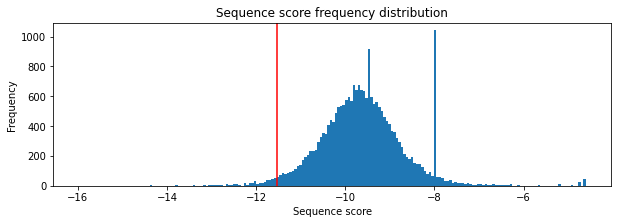

Training 2-gram model
Sequences in corpus:                              22924
Total tokens in corpus:                           470066
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           515914
Flattened sequence set size                       33980
Vocabulary with <UNK> cutoff size                 17643
Creating n-grams
Total ngram sequences:                            22924
Total ngrams:                                     492990
Creating language model
Model vocab size:                                 17644
Total n-grams of size 2 in model:                 17642
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       458/22924
Sequence score cutoff:                            -11.62841227699771



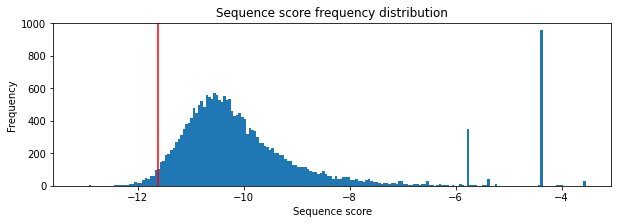

Training 3-gram model
Sequences in corpus:                              22924
Total tokens in corpus:                           470066
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           561762
Flattened sequence set size                       33980
Vocabulary with <UNK> cutoff size                 17643
Creating n-grams
Total ngram sequences:                            22924
Total ngrams:                                     515914
Creating language model
Model vocab size:                                 17644
Total n-grams of size 3 in model:                 195639
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       458/22924
Sequence score cutoff:                            -12.540296373269456



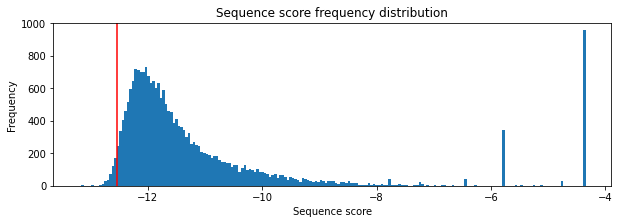

Training 4-gram model
Sequences in corpus:                              22924
Total tokens in corpus:                           470066
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           607610
Flattened sequence set size                       33980
Vocabulary with <UNK> cutoff size                 17643
Creating n-grams
Total ngram sequences:                            22924
Total ngrams:                                     538838
Creating language model
Model vocab size:                                 17644
Total n-grams of size 4 in model:                 367687
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       458/22924
Sequence score cutoff:                            -12.748730388736163



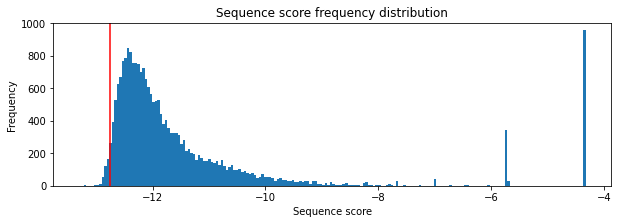

Training 5-gram model
Sequences in corpus:                              22924
Total tokens in corpus:                           470066
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           653458
Flattened sequence set size                       33980
Vocabulary with <UNK> cutoff size                 17643
Creating n-grams
Total ngram sequences:                            22924
Total ngrams:                                     561762
Creating language model
Model vocab size:                                 17644
Total n-grams of size 5 in model:                 441471
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       458/22924
Sequence score cutoff:                            -12.796833244434604



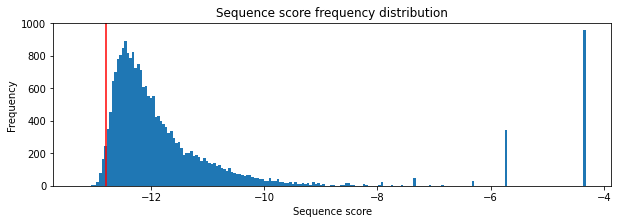

In [42]:
# Text n-gram model
ngram_data_text = train_lm(n_values, tokenized_clean_text_list, alpha=alpha)

Replacing tokens with POS tags using spacy
Training 1-gram model
Sequences in corpus:                              22924
Total tokens in corpus:                           483799
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           483799
Flattened sequence set size                       48
Vocabulary with <UNK> cutoff size                 47
Creating n-grams
Total ngram sequences:                            22924
Total ngrams:                                     483799
Creating language model
Model vocab size:                                 48
Total n-grams of size 1 in model:                 47
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       458/22924
Sequence score cutoff:                            -5.504664788815441



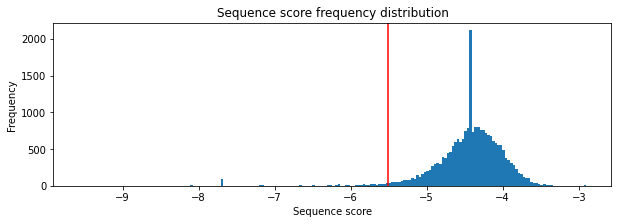

Training 2-gram model
Sequences in corpus:                              22924
Total tokens in corpus:                           483799
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           529647
Flattened sequence set size                       50
Vocabulary with <UNK> cutoff size                 49
Creating n-grams
Total ngram sequences:                            22924
Total ngrams:                                     506723
Creating language model
Model vocab size:                                 50
Total n-grams of size 2 in model:                 48
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       458/22924
Sequence score cutoff:                            -4.29918737232827



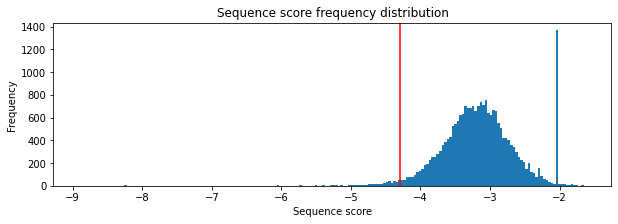

Training 3-gram model
Sequences in corpus:                              22924
Total tokens in corpus:                           483799
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           575495
Flattened sequence set size                       50
Vocabulary with <UNK> cutoff size                 49
Creating n-grams
Total ngram sequences:                            22924
Total ngrams:                                     529647
Creating language model
Model vocab size:                                 50
Total n-grams of size 3 in model:                 1404
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       458/22924
Sequence score cutoff:                            -3.7866925040498063



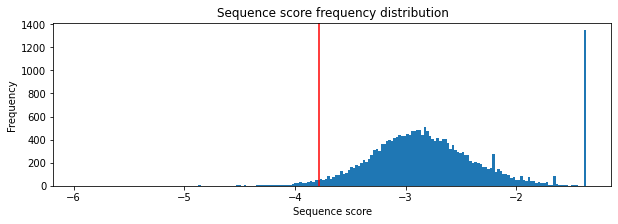

Training 4-gram model
Sequences in corpus:                              22924
Total tokens in corpus:                           483799
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           621343
Flattened sequence set size                       50
Vocabulary with <UNK> cutoff size                 49
Creating n-grams
Total ngram sequences:                            22924
Total ngrams:                                     552571
Creating language model
Model vocab size:                                 50
Total n-grams of size 4 in model:                 14490
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       458/22924
Sequence score cutoff:                            -3.7550120688631248



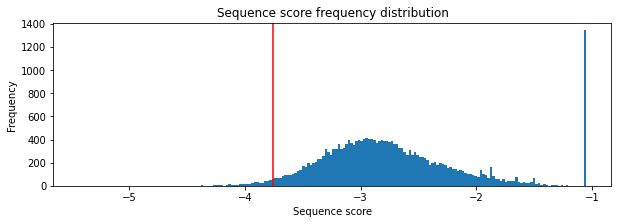

Training 5-gram model
Sequences in corpus:                              22924
Total tokens in corpus:                           483799
Padding sequences with <s> and </s> tokens
Creating vocabulary
Flattened sequence size                           667191
Flattened sequence set size                       50
Vocabulary with <UNK> cutoff size                 49
Creating n-grams
Total ngram sequences:                            22924
Total ngrams:                                     575495
Creating language model
Model vocab size:                                 50
Total n-grams of size 5 in model:                 63635
Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       458/22924
Sequence score cutoff:                            -3.942310221308069



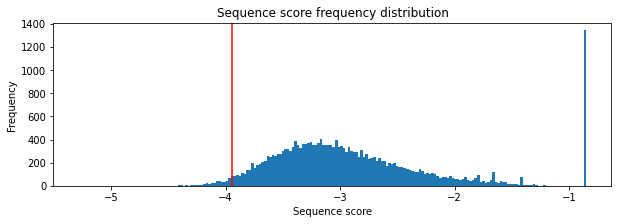

In [43]:
# POS tag n-gram model
clean_pos_tag_list = convert_to_pos_tags(tokenized_clean_text_list, pos_type=pos_type)
ngram_data_pos = train_lm(n_values, clean_pos_tag_list, alpha=alpha)

In [44]:
# Print sample information learned from model

unigram_list = ['<s>', 'of', 'the', 'The', '<UNK>']
# [token, context]
ngram_list = [
    ['The', '<s>'], 
    ['the', 'of'], 
    ['a', 'is'],
    ['a', 'This is'],
    ['a', 'this is'],
    ['The', '<s> <s>'], 
    ['<UNK>', 'What is']
]

heading_df = ['N-gram', 'Context', 'Token', 'Count', 'Score', 'Log Score']
list_to_df = []
for token in unigram_list:
    list_to_df.append([
        '1', '', token, 
        ngram_data_text[1]['model'].counts[token], 
        ngram_data_text[1]['model'].score(token), 
        ngram_data_text[1]['model'].logscore(token)
    ])
for token in ngram_list:
    n_value = len(token[1].split())+1
    if n_value not in n_values:
        raise ValueError(f'{n_value}-gram model not available for the given context size {n_value-1} of "{token[1]}".')
    list_to_df.append([
        n_value, token[1], token[0], 
        ngram_data_text[n_value]['model'].counts[token[1].split()][token[0]], 
        ngram_data_text[n_value]['model'].score(token[0], token[1].split()), 
        ngram_data_text[n_value]['model'].logscore(token[0], token[1].split())
    ])

display(pd.DataFrame(list_to_df, columns = heading_df))

,N-gram,Context,Token,Count,Score,Log Score
0,1,,<s>,0,0.033502,-4.899626
1,1,,of,14508,0.029749,-5.070998
2,1,,the,25242,0.051758,-4.272062
3,1,,The,2859,0.005864,-7.413859
4,1,,<UNK>,16338,0.033502,-4.899626
5,2,<s>,The,2503,0.061724,-4.018036
6,2,of,the,3844,0.119588,-3.063853
7,2,is,a,340,0.015698,-5.993308
8,3,This is,a,13,0.000789,-10.307201
9,3,this is,a,11,0.000677,-10.528698


## Model Evaluation

### Shannon Visualization

In [45]:
def get_sentence_from_tokens(tokens):
    filtered_tokens = []
    for token in tokens:
        if token in ['<s>', '</s>']:
            continue
        else:
            filtered_tokens.append(token)
    return ' '.join(filtered_tokens)

In [46]:
from nltk.probability import MLEProbDist

def shannon_visualization(n_value, model, max_len=50, verbose=False):
    sentence = ""
    if n_value == 1:
        # Unigram
        tokens = model.generate(max_len, random_seed=None)
        sentence = get_sentence_from_tokens(tokens)
        if verbose:
            print('1-gram:', sentence)
    else:
        if verbose:
            print(f'{n_value}-gram: ', end='')
        cur_tokens = ['<s>']*(n_value-1)
        sequence = []
        for _ in range(max_len):
            freq_dist = model.counts[cur_tokens]
            prob_dist = MLEProbDist(freq_dist)
            next_token = prob_dist.generate()
            if next_token == '</s>':
                break
            sequence.append(next_token)
            if verbose:
                print(next_token, end=' ')
            cur_tokens.pop(0)
            cur_tokens.append(next_token)
        sentence = ' '.join(sequence)
        if verbose:
            print()
    return sentence

In [47]:
for n_value in n_values:
    sent = shannon_visualization(n_value, ngram_data_text[n_value]['model'], 50, verbose=False)
    print(f'{n_value}-gram')
    print(f'======')
    print(sent, end='\n\n')

1-gram
too in prepared Af with felt Indonesia the or and being has give so reported aids could the cut , visiting percentage , experimentation trials is you , ! and , he ratio right than inside for worked means time lighted on words for the aloud surrendered writing he but

2-gram
2 ) in the proletariat by a boot of <UNK> .

3-gram
The body caressed through my discovery that many industries can continue to exceed such <UNK> love , faith , and <UNK> with oils from <UNK> .

4-gram
They began to meet in the evenings and carry forward various discussions they felt not fully enough covered in class .

5-gram
Shell people resembled mature <UNK> in size whatever their <UNK> <UNK> were , but the <UNK> leaders went out of their way to be openly <UNK> to Khrushchev , calling him a <UNK> , a <UNK> and <UNK> manner .



## Evaluation functions

In [48]:
def analyse_test_corpus(tokenized_corpus, n_value, model, verbose=False):
    
    if verbose:
        print(f'{"Sequences in corpus:":50}{len(tokenized_corpus)}')
    total_tokens = 0
    for sequence in tokenized_corpus:
        total_tokens += len(sequence)
    if verbose:
        print(f'{"Total tokens in corpus:":50}{total_tokens}')
    
    # padding <s> and </s>
    if verbose:
        print("Padding sequences with <s> and </s> tokens")
    padded_sequences = []
    total_tokens_with_padding = 0
    for i in range(len(tokenized_corpus)):
        padded_tokens = list(pad_sequence(tokenized_corpus[i],
                                          pad_left=True, left_pad_symbol="<s>",
                                          pad_right=True, right_pad_symbol="</s>",
                                          n=n_value))
        padded_sequences.append(padded_tokens)
        total_tokens_with_padding += len(padded_tokens)
    # if verbose:
    #     print('eg.', padded_sequences[0])
    
    # grouping into group size of `n_value`
    if verbose:
        print("Creating n-grams")
    ngram_sequences = []
    for text in padded_sequences:
        ngram_sequences.append(list(ngrams(text, n=n_value)))
    # if verbose:
    #     print('eg.', ngram_sequences[0][:PRINT_LIMIT])
    
    total_ngrams = 0
    for sequence in ngram_sequences:
        total_ngrams += len(sequence)
    if verbose:
        print(f'{"Total ngram sequences:":50}{len(ngram_sequences)}\n{"Total ngrams:":50}{total_ngrams}')    
    
    
    sequence_scores = []
    sequence_token_scores = []
    total_score = 0
    for ngram_sequence in ngram_sequences:
        sequence_score = 0
        sequence_token_score = []
        for group in ngram_sequence:
            score = model.logscore(group[-1], group[:-1])
            sequence_score += score
            sequence_token_score.append(score)
        # sequence_scores.append(sequence_score)
        sequence_scores.append(sequence_score/len(ngram_sequence))
        total_score += sequence_score
        sequence_token_scores.append(sequence_token_score)
    log_perplexity = -total_score/total_tokens_with_padding
    
    return {
        'padded_sequences': padded_sequences,
        'ngram_sequences': ngram_sequences,
        'sequence_scores': sequence_scores,
        'map_to_corpus_index': map_to_corpus_index,
        'perplexity': log_perplexity,
        'sequence_token_scores': sequence_token_scores
    }    

In [49]:
def test_lm(test_corpus, n_values, ngram_data):
    ngram_results = dict()
    for n_value in n_values:
        print(f"Testing {n_value}-gram model")
        ngram_test_info = analyse_test_corpus(test_corpus, n_value, ngram_data[n_value]['model'], verbose=True)
        plot_continuous_freq_dist(ngram_test_info['sequence_scores'], xlabel='Sequence score', 
                                  ylabel='Frequency', title='Sequence score frequency distribution', bins=200,
                                  cutoff=ngram_data[n_value]['score_cutoff'])
        # filter_using_token_score(n_value, ngram_data[n_value]['model'], ngram_test_info['ngram_sequences'], token_log_cutoffs[n_value], verbose=True)
        suspect_sequences_indexes = filter_using_sequence_score(n_value, 
                                                   ngram_test_info['ngram_sequences'], 
                                                   ngram_test_info['sequence_scores'], 
                                                   ngram_data[n_value]['score_cutoff'], verbose=True)
        suspect_corpus_index = []
        for index in suspect_sequences_indexes:
            suspect_corpus_index.append(ngram_test_info['map_to_corpus_index'][index])
        suspect_corpus_index = set(suspect_corpus_index)

        ngram_results[n_value] = dict()
        ngram_results[n_value] = {
            'suspect_corpus_index': suspect_corpus_index,
            'padded_sequences': ngram_test_info['padded_sequences'],
            'ngram_sequences': ngram_test_info['ngram_sequences'],
            'suspect_sequences_index': suspect_sequences_indexes,
            'map_to_corpus_index': ngram_test_info['map_to_corpus_index'],
            'log_perplexity': ngram_test_info['perplexity'],
            'sequence_scores': ngram_test_info['sequence_scores'],
            'sequence_token_scores': ngram_test_info['sequence_token_scores']
        }
        print()
    return ngram_results

In [50]:
def print_stats(text_list, n_values, ngram_results, indexes=None):
    for n_value in n_values:
        if indexes is None:
            continue
        elif indexes == 'all':
            print(f'{n_value}-gram')
            for index in range(len(text_list)):
                print(f"\t{index}:\t{index in ngram_results[n_value]['suspect_corpus_index']}")
        else:
            print(f'{n_value}-gram')
            for index in indexes:
                print(f"\t{index}:\t{index in ngram_results[n_value]['suspect_corpus_index']}")
    
    print('Total sequence generated from unknown corpus:\t', len(ngram_results[n_values[-1]]['padded_sequences']))
    print('Total text files in unknown corpus:\t\t', len(text_list))
    heading_df = ['N-gram', 'Suspect sequences', 'Suspect files']
    list_to_df = []
    for n_value in n_values:
        list_to_df.append([
            n_value,
            len(ngram_results[n_value]['suspect_sequences_index']), 
            len(ngram_results[n_value]['suspect_corpus_index'])
        ])
    display(pd.DataFrame(list_to_df, columns = heading_df))

## Log Perplexity Calculation

In [51]:
def calculate_log_perplexity(text_dev_list, n_values, ngram_data):   
    perplexity = dict()
    for n_value in n_values:
        ngram_test_info = analyse_test_corpus(tokenized_corpus, n_value, 
                                              ngram_data[n_value]['model'], verbose=False)
        perplexity[n_value] = ngram_test_info['perplexity']
    return perplexity

In [52]:
segmented_corpus, map_to_corpus_index = segmentation(clean_text_dev_list)
tokenized_corpus = tokenization(segmented_corpus)

# Perplexity of clean text dev set
print("Text n-gram model log perplexities:")
clean_text_dev_perplexity = calculate_log_perplexity(tokenized_corpus, n_values, ngram_data_text)
for n_value in n_values:
    print(f"\t{n_value}-gram perplexity =", clean_text_dev_perplexity[n_value])

print()
# Perplexity of clean text POS dev set
tokenized_pos_corpus = convert_to_pos_tags(tokenized_corpus, pos_type=pos_type)
print("POS tag n-gram model log perplexities:")
clean_text_dev_pos_perplexity = calculate_log_perplexity(tokenized_pos_corpus, n_values, ngram_data_pos)
for n_value in n_values:
    print(f"\t{n_value}-gram perplexity =", clean_text_dev_pos_perplexity[n_value])

Text n-gram model log perplexities:
	1-gram perplexity = 9.434752324650805
	2-gram perplexity = 10.07546264078466
	3-gram perplexity = 11.328138494359285
	4-gram perplexity = 11.336285125903515
	5-gram perplexity = 11.067435739363184

Replacing tokens with POS tags using spacy
POS tag n-gram model log perplexities:
	1-gram perplexity = 15.86727411316513
	2-gram perplexity = 6.054250274397729
	3-gram perplexity = 5.312150841222204
	4-gram perplexity = 5.112297959879304
	5-gram perplexity = 4.948794704626503


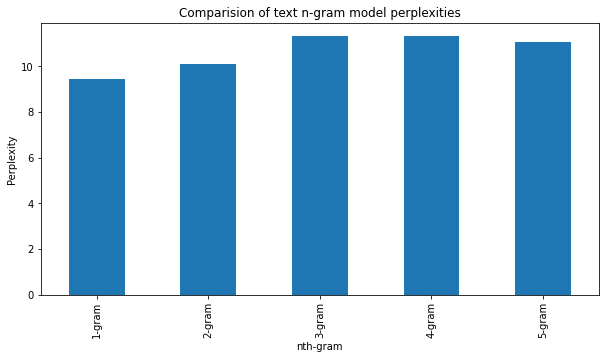

In [53]:
text_n_gram_perplexities = []
for n_value in n_values:
    text_n_gram_perplexities.append(clean_text_dev_perplexity[n_value])

freq_series = pd.Series(text_n_gram_perplexities)
x_labels = [f'{n_value}-gram' for n_value in n_values]
plt.figure(figsize=(10, 5))
ax = freq_series.plot(kind="bar")
ax.set_title("Comparision of text n-gram model perplexities")
ax.set_xlabel("nth-gram")
ax.set_ylabel("Perplexity")
ax.set_xticklabels(x_labels)
rects = ax.patches
plt.show()

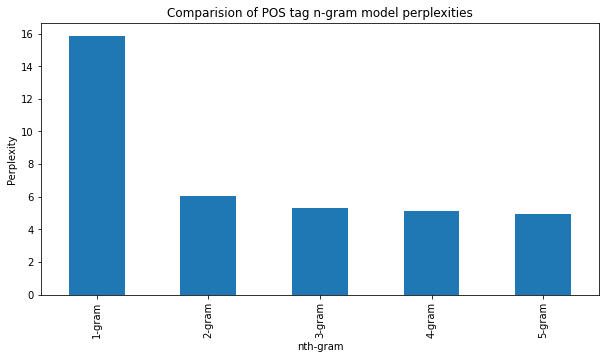

In [54]:
pos_perplexities = []
for n_value in n_values:
    pos_perplexities.append(clean_text_dev_pos_perplexity[n_value])

freq_series = pd.Series(pos_perplexities)
x_labels = [f'{n_value}-gram' for n_value in n_values]
plt.figure(figsize=(10, 5))
ax = freq_series.plot(kind="bar")
ax.set_title("Comparision of POS tag n-gram model perplexities")
ax.set_xlabel("nth-gram")
ax.set_ylabel("Perplexity")
ax.set_xticklabels(x_labels)
rects = ax.patches
plt.show()

## Evaluating unknown corpus

In [55]:
test_text_list = None
# test_text_list = ["In the country there lived a fox. The quick brown fox jump over the fence. " \
#                    "Farmer Shaun was terrified."]

if test_text_list is None:
    test_text_list = unknown_text_list
segmented_corpus, map_to_corpus_index = segmentation(test_text_list)
tokenized_corpus = tokenization(segmented_corpus)

Testing 1-gram model
Sequences in corpus:                              30868
Total tokens in corpus:                           669821
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            30868
Total ngrams:                                     669821


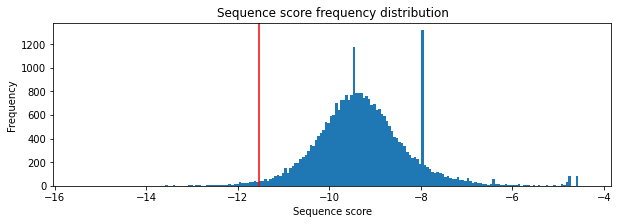

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       372/30868

Testing 2-gram model
Sequences in corpus:                              30868
Total tokens in corpus:                           669821
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            30868
Total ngrams:                                     700689


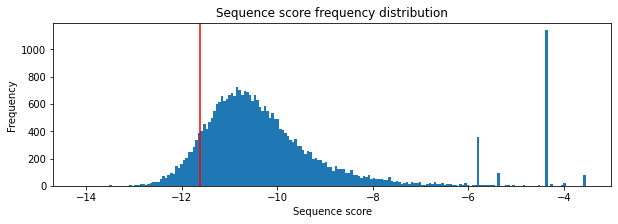

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       2806/30868

Testing 3-gram model
Sequences in corpus:                              30868
Total tokens in corpus:                           669821
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            30868
Total ngrams:                                     731557


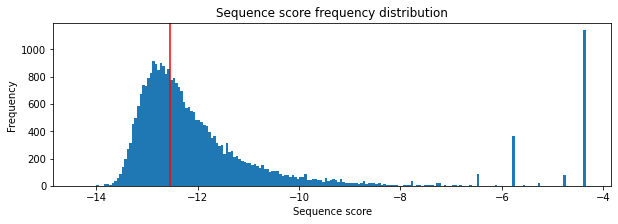

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       12651/30868

Testing 4-gram model
Sequences in corpus:                              30868
Total tokens in corpus:                           669821
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            30868
Total ngrams:                                     762425


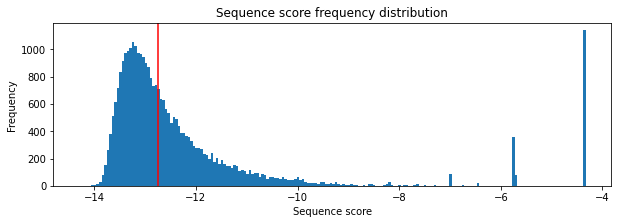

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       16627/30868

Testing 5-gram model
Sequences in corpus:                              30868
Total tokens in corpus:                           669821
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            30868
Total ngrams:                                     793293


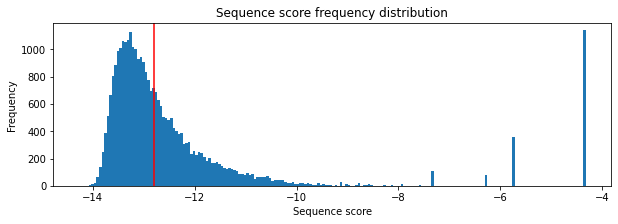

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       17678/30868



In [56]:
# Text n-gram model
ngram_results_text = test_lm(tokenized_corpus, n_values, ngram_data_text)
ngram_results_text['segmented_corpus'] = segmented_corpus

Replacing tokens with POS tags using spacy
Testing 1-gram model
Sequences in corpus:                              30868
Total tokens in corpus:                           676560
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            30868
Total ngrams:                                     676560


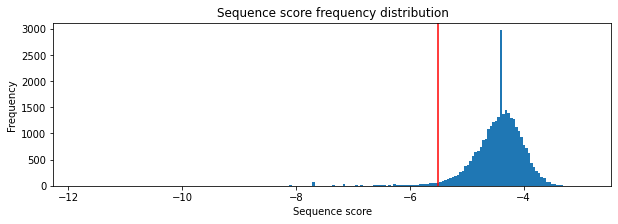

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       692/30868

Testing 2-gram model
Sequences in corpus:                              30868
Total tokens in corpus:                           676560
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            30868
Total ngrams:                                     707428


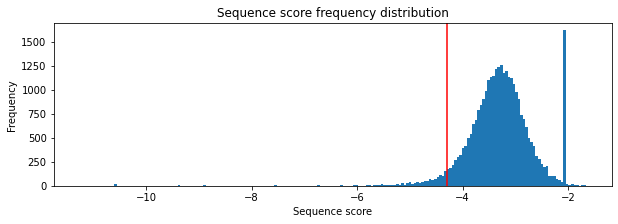

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       1269/30868

Testing 3-gram model
Sequences in corpus:                              30868
Total tokens in corpus:                           676560
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            30868
Total ngrams:                                     738296


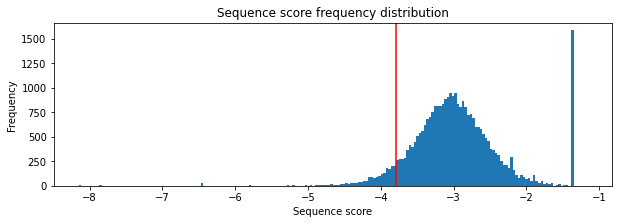

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       2049/30868

Testing 4-gram model
Sequences in corpus:                              30868
Total tokens in corpus:                           676560
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            30868
Total ngrams:                                     769164


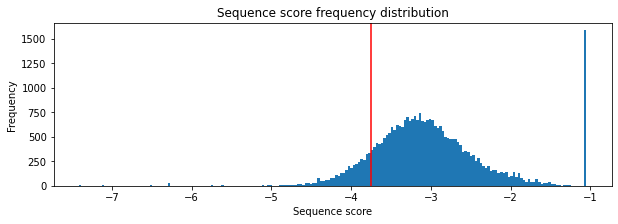

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       3702/30868

Testing 5-gram model
Sequences in corpus:                              30868
Total tokens in corpus:                           676560
Padding sequences with <s> and </s> tokens
Creating n-grams
Total ngram sequences:                            30868
Total ngrams:                                     800032


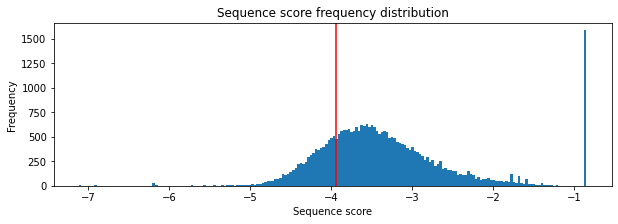

Filtering sequences based on sequence scores
Suspect sequences based on sequence scores:       6945/30868



In [57]:
# POS tag n-gram model
pos_corpus = convert_to_pos_tags(tokenized_corpus, pos_type=pos_type)
ngram_results_pos = test_lm(pos_corpus, n_values, ngram_data_pos)
ngram_results_pos['segmented_corpus'] = pos_corpus

In [58]:
print_stats(test_text_list, n_values, ngram_results_text)
# print_stats(test_text_list, n_values, ngram_results_text, indexes='all')
# print_stats(test_text_list, n_values, ngram_results_text, indexes=[i for i in range(min(3, len(test_text_list)))])

Total sequence generated from unknown corpus:	 30868
Total text files in unknown corpus:		 8698


,N-gram,Suspect sequences,Suspect files
0,1,372,355
1,2,2806,2238
2,3,12651,6195
3,4,16627,7052
4,5,17678,7245


In [59]:
print_stats(test_text_list, n_values, ngram_results_pos)
# print_stats(test_text_list, n_values, ngram_results_pos, indexes='all')
# print_stats(test_text_list, n_values, ngram_results_pos, indexes=[i for i in range(min(3, len(test_text_list)))])

Total sequence generated from unknown corpus:	 30868
Total text files in unknown corpus:		 8698


,N-gram,Suspect sequences,Suspect files
0,1,692,612
1,2,1269,1104
2,3,2049,1680
3,4,3702,2734
4,5,6945,4366


In [60]:
common_suspects = dict()
print(f"Size of combined suspect set:")
for n_value in n_values:
    common_suspects[n_value] = list(set(ngram_results_text[n_value]['suspect_corpus_index']) & set(ngram_results_pos[n_value]['suspect_corpus_index']))
    print(f"\t{n_value}-gram: {len(common_suspects[n_value])}/{len(test_text_list)}")

Size of combined suspect set:
	1-gram: 63/8698
	2-gram: 420/8698
	3-gram: 1343/8698
	4-gram: 2432/8698
	5-gram: 4055/8698


### Output

#### Displaying random segment classified as suspect by models

In [61]:
def print_corpus_text_from_suspect_sequence_index(index, corpus, n_value, ngram_results):
    n = len(ngram_results[n_value]['suspect_sequences_index'])
    if n == 0:
        return
    index %= n
    sequence_index = ngram_results[n_value]['suspect_sequences_index'][index]
    print('Segment text\n============\n', get_sentence_from_tokens(ngram_results_text[n_value]['padded_sequences'][sequence_index]))
    print('\nSegment POS tags\n================\n', get_sentence_from_tokens(ngram_results_pos[n_value]['padded_sequences'][sequence_index]))
    corpus_index = ngram_results[n_value]['map_to_corpus_index'][sequence_index]
    print('\nCorpus text\n===========\n', corpus[corpus_index])

In [62]:
# Print random suspected sequence
print_corpus_text_from_suspect_sequence_index(
    index=random.randint(0, len(ngram_results_text[n_value]['suspect_sequences_index'])), 
    corpus=test_text_list, n_value=n_values[-1], 
    ngram_results=ngram_results_text
)

Segment text
 An important observation of Pavlov served as a guide post to achieve such a reversibility by physiological means .

Segment POS tags
 DT JJ NN IN NNP VBD IN DT NN NN TO VB PDT DT NN IN JJ NNS .

Corpus text
 Wolpe 's experiments and therapeutic work lies in this area . He showed convincingly that anxiety is a learned ( conditioned ) reaction and is the basis of experimental and clinical neuroses and assumed , therefore , that the neuronal changes which underlie the neuroses are functional and reversible . An important observation of Pavlov served as a guide post to achieve such a reversibility by physiological means . In a conditioning experiment , he demonstrated the antagonism between feeding and pains . A mild electrical shock served as a conditioned stimulus and was followed by feeding . The pain became thus the symbol for food and elicited salivary secretion ( conditioned reflex ) . Even when the intensity of the shocks was increased gradually , it failed to evoke an

#### Testing if a sentence in corpus is classified as suspect by both models (text, POS tag)

In [63]:
# Check if sentence in test corpus is grammatically correct
corpus_index_to_check = 0
print(test_text_list[corpus_index_to_check])
for n_value in n_values:
    print(f'\t{n_value}-gram: \t{corpus_index_to_check not in common_suspects[n_value]}') 

The Fulton County Grand Jury say Friday an investigation of Atlanta 's recent primary election produced ` ` no evidence '' that any irregularities took place .
	1-gram: 	True
	2-gram: 	True
	3-gram: 	True
	4-gram: 	True
	5-gram: 	True


In [64]:
def suggest_corrections(strategy, n_value, ngram_data_text, ngram_data_pos, ngram_results_text, ngram_results_pos, print_limit=10):
    
    # results used for thresholding
    if strategy == 'pos':
        ngram_results = ngram_results_pos
        cutoff = ngram_data_pos[n_value]['score_cutoff']
    elif strategy == 'text':
        ngram_results = ngram_results_text
        cutoff = ngram_data_text[n_value]['score_cutoff']
    elif strategy == 'both':
        raise ValueError('strategy not implemented')
    print(f'Thresholding done using "{strategy}" sequence scores')
    print(f'{n_value}-gram cutoff:\t{cutoff}')
    
    data = {
        'Text': [],
        'Text score': [],
        'POS score': [],
        'Wrong token': [],
        'Wrong token score': [],
        'Wrong token POS': [],
        'Wrong token POS score': [],
        'Suggested token': []
    }    
    for index in ngram_results[n_value]['suspect_sequences_index']:
        
        token_scores = ngram_results[n_value]['sequence_token_scores'][index]
        min_val, min_idx = min((val, idx) for (idx, val) in enumerate(token_scores))
        # text_token_scores = ngram_results_text[n_value]['sequence_token_scores'][index]
        # min_text_token_val, min_text_token_idx = min((val, idx) for (idx, val) in enumerate(text_token_scores))
        
        data['Text'].append(ngram_results_text['segmented_corpus'][index])
        data['Text score'].append(ngram_results_text[n_value]['sequence_scores'][index])
        data['POS score'].append(ngram_results_pos[n_value]['sequence_scores'][index])
        data['Wrong token'].append(ngram_results_text[n_value]['ngram_sequences'][index][min_idx])
        data['Wrong token score'].append(ngram_results_text[n_value]['sequence_token_scores'][index][min_idx])
        data['Wrong token POS'].append(ngram_results_pos[n_value]['ngram_sequences'][index][min_idx])
        data['Wrong token POS score'].append(min_val)
        
        if strategy == 'pos':
            # Get highest P(pos|pos_context)
            # Get highest P(text|pos)
            data['Suggested token'].append('')
        elif strategy == 'text':
            # Get highest P(text|text_context)
            data['Suggested token'].append('')
        elif strategy == 'both':
            raise ValueError('strategy not implemented')
            
        print_limit -= 1
        if print_limit <= 0:
            break
            
    display(pd.DataFrame(data))

    for text in data['Text']:
        print(text, end='\n\n')
    
suggest_corrections('pos', 4, ngram_data_text, ngram_data_pos, ngram_results_text, ngram_results_pos, print_limit=20)

Thresholding done using "pos" sequence scores
4-gram cutoff:	-3.7550120688631248


,Text,Text score,POS score,Wrong token,Wrong token score,Wrong token POS,Wrong token POS score,Suggested token
0,Regarding Atlanta 's new multi - million - dol...,-13.283717,-4.048989,"(`, `, that, when)",-14.107054,"(``, ``, IN, WRB)",-8.495855,
1,"Let her call Crosson if she wanted to , let Cr...",-13.178422,-4.329182,"(she, wanted, to, ,)",-14.106890,"(PRP, VBD, TO, ,)",-8.224002,
2,He plus tried to ignore what his own common se...,-12.859730,-3.857308,"(<s>, <s>, He, plus)",-14.200669,"(<s>, <s>, PRP, CC)",-8.066474,
3,"Nothing bald , openest ; ; but enough .",-11.992259,-4.209890,"(;, but, enough, .)",-14.106890,"(:, CC, RB, .)",-6.768184,
4,She was married to him for better or for worse .,-12.089369,-3.789318,"(to, him, for, better)",-14.106972,"(IN, PRP, IN, RBR)",-8.134426,
5,She would n't 21-2 be wilfully planning his de...,-12.115059,-3.791140,"(She, would, n't, 21-2)",-14.106972,"(PRP, MD, RB, CD)",-9.211888,
6,"What was that old sign ,s supposed to be paint...",-13.317458,-3.890438,"(sign, ,, s, supposed)",-14.106890,"(NN, ,, PRP, VBN)",-9.266787,
7,"Why , Holden to himself , surprised at his own...",-13.369788,-3.971512,"(as, happy, as, can)",-14.106972,"(RB, JJ, IN, MD)",-9.451211,
8,Good --ed bye .,-10.179000,-4.203415,"(<s>, <s>, <s>, Good)",-12.308055,"(<s>, <s>, <s>, UH)",-7.746247,
9,Glad see you go .,-10.903088,-3.969089,"(<s>, <s>, Glad, see)",-14.204877,"(<s>, <s>, NNP, VB)",-9.938844,


Regarding Atlanta 's new multi - million - dollar airport , the jury recommended ` ` that when the new sandra management takes charge Jan. 1 the airport be operated in a manner that will eliminate political influences '' .

Let her call Crosson if she wanted to , let Crosson raise the roof or even can him , he did n't care macdonald's .

He plus tried to ignore what his own common sense told him , but it was n't possible ; ; her returning motives were too blatant .

Nothing bald , openest ; ; but enough .

She was married to him for better or for worse .

She would n't 21-2 be wilfully planning his destruction .

What was that old sign ,s supposed to be painted over a door somewhere , Abandon hope , all ye who enter here ?

Why , Holden to himself , surprised at his own sudden insight , I 'll bet some of those people who enter are just as happy as can be .

Good --ed bye .

Glad see you go .

What do you '' --

` ` Why onning earth did I send him off to work ?

?ed Different about ther

### Saving model

In [65]:
import dill as pickle 

os.makedirs(os.path.join(BASE_DIR, 'models'), exist_ok=True)

for n_value in n_values:
    with open(os.path.join(BASE_DIR, 'models', f'{n_value}_gram_text.pkl'), 'wb') as fout:
        pickle.dump(ngram_data_text[n_value]['model'], fout)
        
for n_value in n_values:
    with open(os.path.join(BASE_DIR, 'models', f'{n_value}_gram_pos.pkl'), 'wb') as fout:
        pickle.dump(ngram_data_pos[n_value]['model'], fout)

## Contribution
- Adarsh Nandanwar [2018A7PS0396G] - Language Model (n-gram) Train and Test, Language Model Evaluation
- Yash Narang [2018A7PS0150G] - POS Tagging: Hidden Markov Model
- Manav Mehta [2018A7PS0164G] - Dataset Analysis
- Aditya Jain [2018A7PS0243G] - POS Tagging: Spacy, Perplexity Calculation
- Pranav Gaur [2018A7PS0099G] - POS Tagging: Spacy, Perplexity Calculation